# **Практика: использование Permutation importnace для оценки важности признаков в линейной модели**

В ходе уроков модуля вы детально изучили permutation importance теоретически. В этом ноутбуке мы предлагаем использовать и проанализировать данный способ оценки важности признаков на практике!

В качестве набору данных будем использовать встроенный dataset из sklearn 'fetch_california_housing'. Он был составлен на основе данных переписи населения Калифорнии 1990 года. Каждая строка в наборе данных представляет отдельный жилой район и содержит информацию о средних характеристиках домов в этом районе.

**Основные характеристики:**

**Целевая переменная (target):**

- `MedHouseVal` — средняя стоимость домов в данном районе, выраженная в сотнях тысяч долларов.

**Признаки (features):**

- `MedInc` (Median Income): медианный доход в районе (в десятках тысяч долларов)

- `HouseAge` (Housing Median Age): медианный возраст домов в районе (в годах)
- `AveRooms` (Average Rooms per Dwelling): среднее количество комнат на одно жилье.
- `AveBedrms` (Average Bedrooms per Dwelling): среднее количество спален на одно жилье.
- `Population (Population):` численность населения в районе.
-  `AveOccup (Average Occupancy):` среднее количество жильцов на одно жилище.
-  `Latitude (Latitude):` географическая широта района.
- `Longitude (Longitude):` географическая долгота района.

Датасет не содержит пропусков и является отличным для нашей практической задачи – оценить важность признаков. Приятного прохождения заданий!

[![jean-louis-paulin-lHwmE58fW4Y-unsplash.md.jpg](https://ltdfoto.ru/images/2024/05/26/jean-louis-paulin-lHwmE58fW4Y-unsplash.md.jpg)](https://ltdfoto.ru/image/OHu52C)

# Предобработка данных

В рамках данного урока мы применим простую предобработку — просто нормализуем все значения. Для интереса добавим пару рандомных признаков.

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

data = pd.read_csv('https://github.com/aiedu-courses/all_datasets/raw/main/fetch_california_housing.csv',
                   index_col=0)
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41,6.984127,1.023810,322,2.555556,37.88,-122.23,4.526
1,8.3014,21,6.238137,0.971880,2401,2.109842,37.86,-122.22,3.585
2,7.2574,52,8.288136,1.073446,496,2.802260,37.85,-122.24,3.521
3,5.6431,52,5.817352,1.073059,558,2.547945,37.85,-122.25,3.413
4,3.8462,52,6.281853,1.081081,565,2.181467,37.85,-122.25,3.422


In [17]:
X, y = data.drop('target', axis=1), data['target']

rng = np.random.RandomState(0)
bin_var = pd.Series(rng.randint(0, 1, X.shape[0]), name="rnd_bin")
num_var = pd.Series(np.arange(X.shape[0]), name="rnd_num")
X_with_rnd_feat = pd.concat((X, bin_var, num_var), axis=1)

#разделим на тренировочный и тестовый наборы

X_train, X_test, y_train, y_test = train_test_split(
    X_with_rnd_feat, y, random_state=42
)

# Анализ переменных

Чтобы не работать с признаками вслепую, извлечем базовую информацию о взаимосвязи:
- признаков друг с другом
- признаков с целевой переменной.

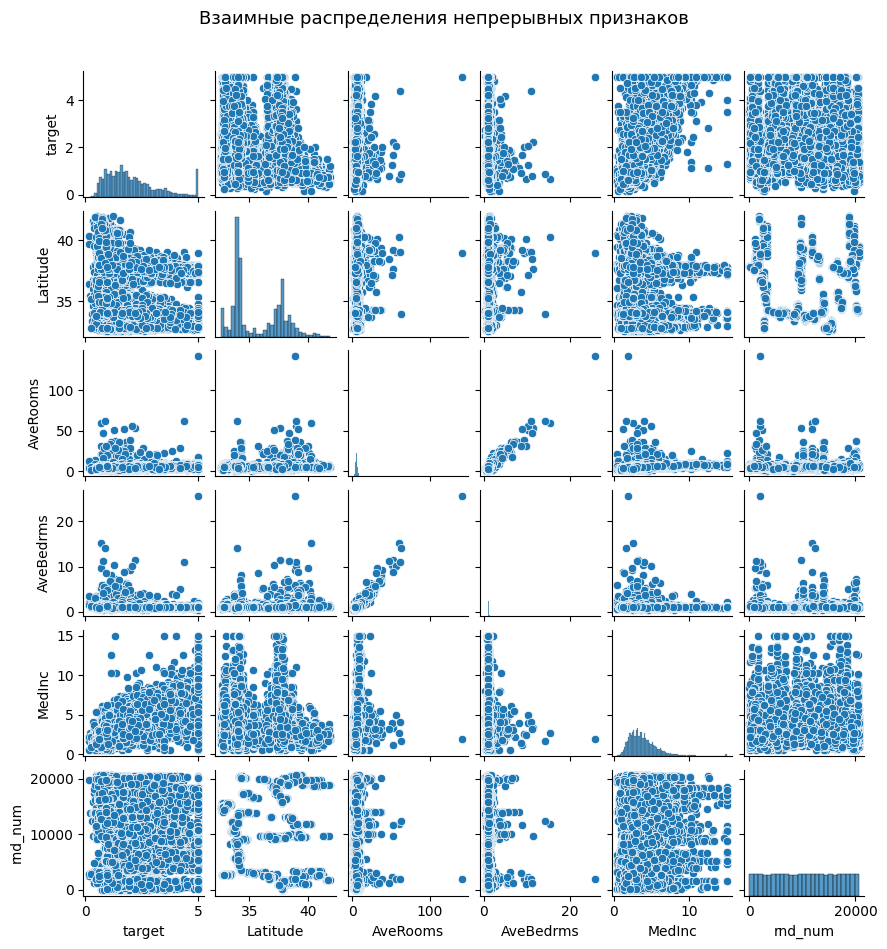

In [20]:
#Создадим экземпляр, в который добавим целевую переменную
train_dataset = X_train.copy()
train_dataset.insert(0, "target", y_train)
g = sns.pairplot(
    train_dataset[
        ["target", "Latitude", "AveRooms", "AveBedrms", "MedInc", 'rnd_num']
    ],
    height=1.5
)

g.fig.suptitle('Взаимные распределения непрерывных признаков',
               y=1.05,
               fontsize=13
);

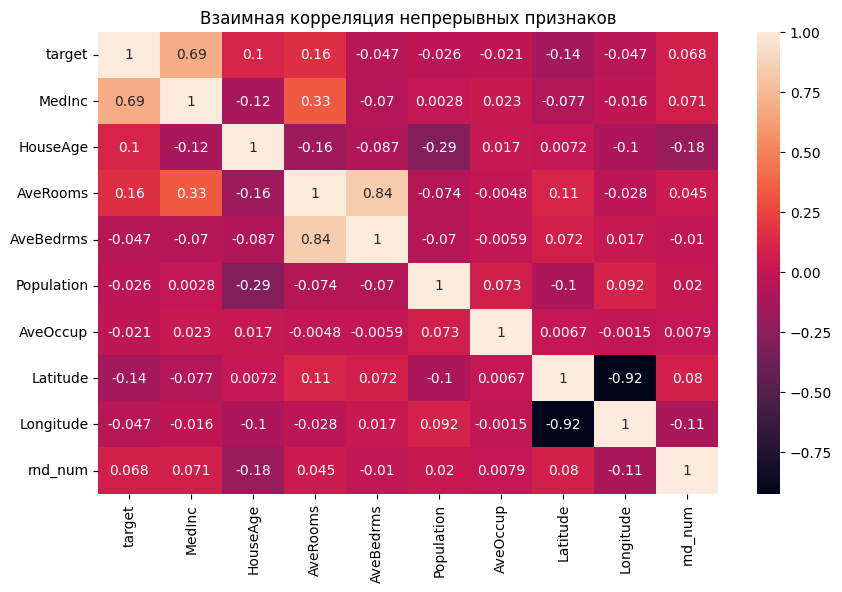

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(train_dataset.drop('rnd_bin', axis=1).corr(), annot=True)

ax.set_title('Взаимная корреляция непрерывных признаков');

**Место для ваших выводов:**
- ...
- ...

**Quize 1: Сколько пар признаков сильно скоррелированы (значение корреляции >= 0.5)?** \
**Ответ:**

**Quize 2: Какой признак, если оценивать по линейной корреляции, сильнее всего связан с целевой переменной?** \
**Ответ:**

Обучим линейную модель. Будем использовать `Lasso` из sklearn, чтобы сразу добавить возможные преимущества, в виде выбора признаков при помощи регуляризации, в модель.


**Quize 3:Обучите модель. Чему равно качество (метрика R2) модели на тестовых данных?** **Ответ округлите до сотых.**\
**Ответ:**

In [21]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = Lasso(alpha=0.015)

#Обучите модель. Чему равно качество модели на тренировочных и тестовых данных?

lasso_model = make_pipeline(StandardScaler(), model)

# Ваш код здесь
lasso_model

print(f"Качество модели на тренировочных данных: {lasso_model.score(X_train, y_train)}")
print(f"Качество модели на тестовых данных: {lasso_model.score(X_test, y_test)}")

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.015))])

**Quize 4: Взглянем на коэффициенты модели. Какой признак оказался наиболее важным?**

In [23]:
coefs = pd.DataFrame(
    lasso_model[1].coef_, columns=["Coefficients"], index=X_train.columns
)

#Ваш код здесь
coefs.plot(kind=, figsize=(9, 7))
plt.title("Модель Lasso с сильной регуляризацией")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [24]:
coefs

**Ответ:**

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    lasso_model,
    X_with_rnd_feat,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [model[1].coef_ for model in cv_model["estimator"]],
    columns=X_with_rnd_feat.columns,
)
plt.figure(figsize=(9, 7))
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Важность коэффициентов")
plt.title("Важность коэффициентов и их изменчивость")
plt.subplots_adjust(left=0.3)

**Quize 5: Проанализируем изменение разброса признаков при проведении кросс-валидации.**

**У какого признака наибольший разброс? (рассмотрите стандартное отклонение)**

In [ ]:
coefs

**Ответ:**

# Feature importance by permutation

Напомним алгоритм вычисления перестановочной важности признаков.

1. Обучим модель `model`. Вычислим её базовое качество `baseline_score`.
2. Зафиксируем признак $f_i$. Зададим число раундов перестановки `n_repeats`.
3. Для каждого $j$ от 0 до `n_repeats`:
 - выполним случайную перестановку признака $f_i$
 - обучим модель на датасете, где признак $f_i$ переставлен
 - вычислим качество новой модели `permuted_score`
 - оценим изменение `change` равное `baseline_score - permuted_score`
 - сохраним полученное значение
4. Важность признака $f_i$ представим как среднюю важность в результате перестановок.  


**Quize 6: Используйте `permutation_importance` из sklearn с количеством повторений 10. Какой признак имеет нулевую важность?**

In [ ]:
from sklearn.inspection import permutation_importance

perm_results = permutation_importance(scoring='neg_mean_squared_error',
                                      random_state=17)

permutation_imp_data = pd.DataFrame(perm_results.importances_mean, columns=['importances'], index=X_train.columns)
permutation_imp_data['importances_std'] = perm_results.importances_std

In [ ]:
permutation_imp_data.sort_values(by='importances_std')

**Ответ:**

# Что можно сказать о перестановочной важности?
**Quize 7-8: Зафиксируйте свои выводы. Выберите верные на степик.**

# Какой из выводов предыдущего шага нельзя обобщить на все модели?

**Ответ**


In [ ]:
!pip install eli5 -q

**Quize 9: Используйте перестановочную важность из eli5. Можно ли сказать, что важности реализации в sklearn и eli5 дают эквивалентные коэффициенты?**

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(...)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())